Poor element choice can prevent FEniCSx from giving reasonable results. In the same example of 2D flow through a channel, the driving pressure is increased to 50, and linear elements are used for both the velocity and pressure spaces. The use of linear elemetns for both function spaces causes spurious oscialltions (https://jsdokken.com/dolfinx-tutorial/chapter2/ns_code1.html), which means that the y-velocity (Uy) is nonzero. In this case, we find that the maximum y velocity is 0.424, which is about 6.57% of the maximum velocity magnitude. 

In the second block of code, the element type for the velocity is changed to quadratic. In these results, we see the maximum vertical velocity is 0.0399, an order of magnitude smaller than in the first case. 

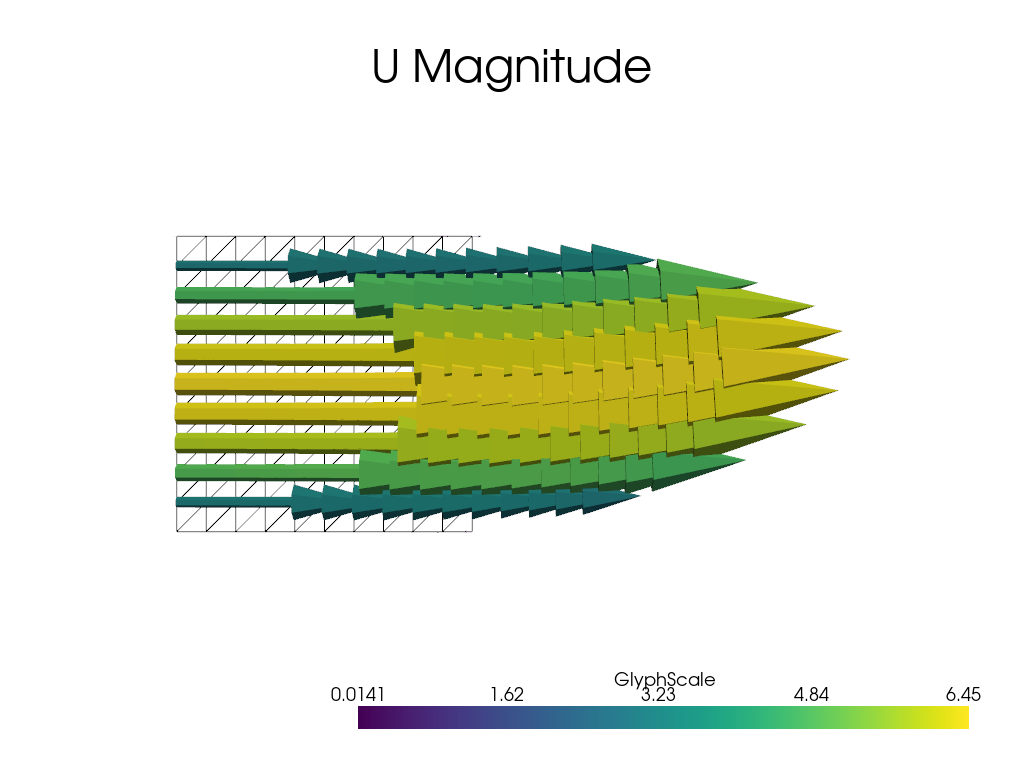

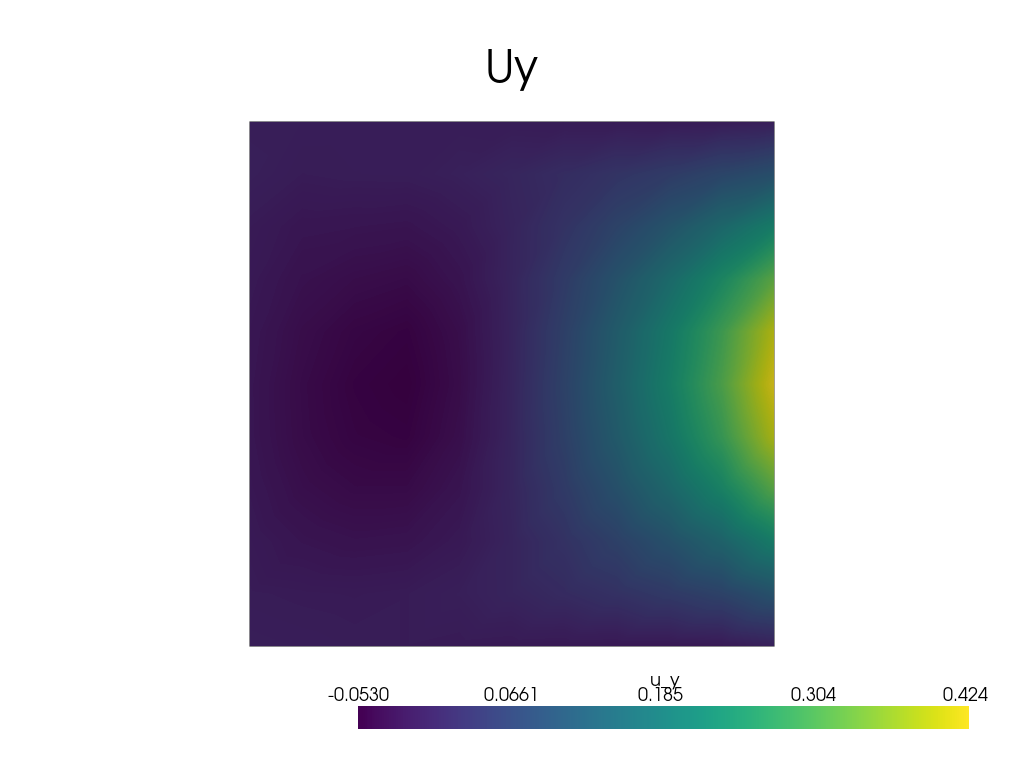

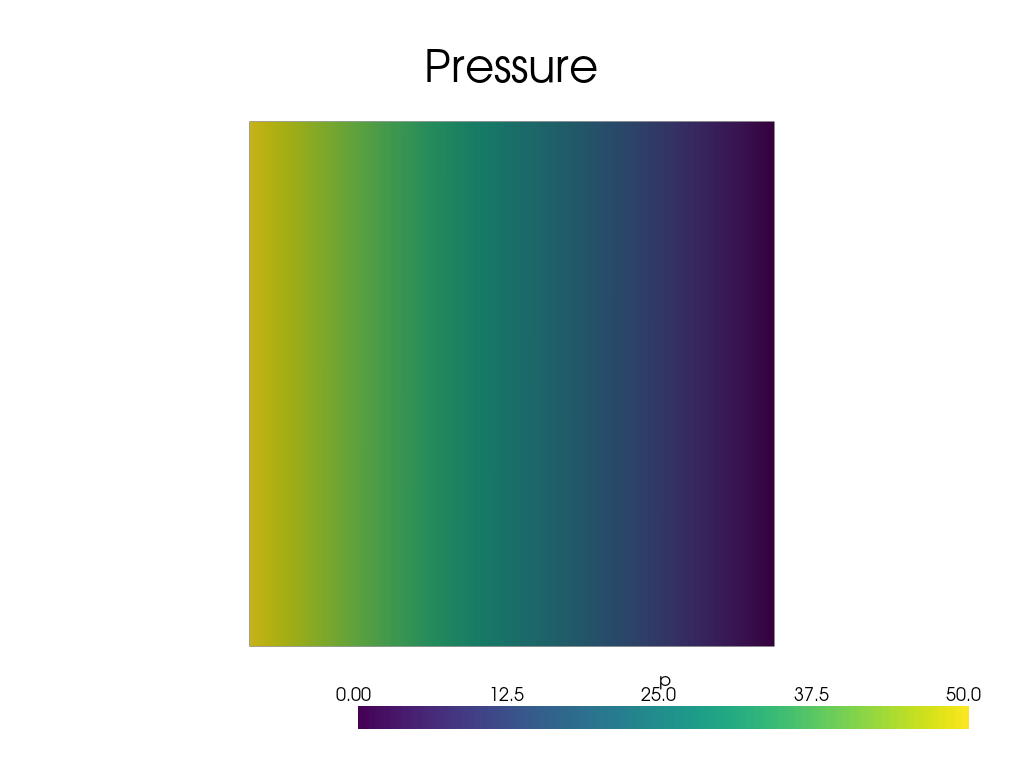

In [1]:
# **** IMPORT *** #

from mpi4py import MPI  # for parallel
from petsc4py import PETSc # matrix solver library
import numpy as np # for array manipulation
import pyvista # visualization
import matplotlib.pyplot as plt

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical # define constants and functions, boundary conditions, 
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc # assemble matrix equations, apply and enforce BC
from dolfinx.io import VTXWriter # write to VTX
from dolfinx.mesh import create_unit_square # create square mesh
from dolfinx.plot import vtk_mesh # plot VTK mesh
from basix.ufl import element # make elements
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction, # face normal vector, identity matrix, test and trial functions
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym) # descirbe the variational form symbolically. math terms


t = 0 # initial time
T = 10 # total simulation time
num_steps = 10 # number of timesteps
dt = T / num_steps # calculate timestep 
maxU = []
maxUerr = []
nx = 10

# *** MESH *** #

mesh = create_unit_square(MPI.COMM_WORLD, nx, nx)
mid = nx / 2

# *** FUNCTION SPACE *** #

# Taylor Hood elements
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 1, shape=(mesh.geometry.dim, )) # define piecewise quadratic elements, vector should have same dimension as the mesh
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1) # define piecewise linear elements
V = functionspace(mesh, v_cg2) # velocity function space
Q = functionspace(mesh, s_cg1) # pressure function space

# *** TRIAL FUNCTIONS *** #

u = TrialFunction(V) # trial functions for velocity
v = TestFunction(V) # admissable variations of V (velocity)
p = TrialFunction(Q) # trial functions for pressure
q = TestFunction(Q) # admissable variations of Q (pressure)


# *** DEFINE BOUNDARY CONDITIONS *** #

def walls(x): # define where the walls are
        return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], 1))

wall_dofs = locate_dofs_geometrical(V, walls) # find the dofs on the walls
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define no slip zero velocity, velocity vector has same dimension as the mesh
bc_noslip = dirichletbc(u_noslip, wall_dofs, V) # apply no slip to walls dof, array of scalars, V = 0

def inflow(x): # define where the inlet is
    return np.isclose(x[0], 0)

inflow_dofs = locate_dofs_geometrical(Q, inflow) # find dofs at the inlet
bc_inflow = dirichletbc(PETSc.ScalarType(50), inflow_dofs, Q) # assign Dirichlet BC at inlet dofs, p = 8, scalar

def outflow(x): # define where the outlet is
    return np.isclose(x[0], 1)

outflow_dofs = locate_dofs_geometrical(Q, outflow) # find dofs at the outlet
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q) # assign Dirichlet BC at outlet dofs, p = 0, scalar
bcu = [bc_noslip]
bcp = [bc_inflow, bc_outflow]


# *** DEFINE CONSTANTS/VARIABLES *** #

f = Constant(mesh, PETSc.ScalarType((0, 0))) # additional body forces (none here)
k = Constant(mesh, PETSc.ScalarType(dt)) # timestep
mu = Constant(mesh, PETSc.ScalarType(1)) # viscosity
rho = Constant(mesh, PETSc.ScalarType(1)) # density

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))

n = FacetNormal(mesh) # normal vector

# *** FIRST VARIATIONAL FORM *** #

# first variational problem
u_n = Function(V)  # velocity form last time
u_n.name = "u_n" # name the variable
U = 0.5 * (u_n + u) # velocity predictor (u^{n+1/2})

# Define the variational problem for the first step
# <trial function, test function>

p_n = Function(Q) # pressure from last step 
p_n.name = "p_n" # name variable
F1 = rho * dot((u - u_n) / k, v) * dx # first term eq. 39
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx # second term eq.39
F1 += inner(sigma(U, p_n), epsilon(v)) * dx # third term eq. 39
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds # fourth term eq 39
F1 -= dot(f, v) * dx # fifth term eq. 39
a1 = form(lhs(F1)) # a1 = LHS of eq. 39
L1 = form(rhs(F1)) # L1 = rhs of eq. 39

# assemble matrix equation : A1*U = b1
A1 = assemble_matrix(a1, bcs=bcu) # assemble matrix for lhs of 39, note boundary conditions
A1.assemble() # assemble step
b1 = create_vector(L1) # rhs of equation to be solved

# *** SECOND VARIATIONAL FORM *** #

# Define variational problem for step 2
u_ = Function(V) # u_ = velocity prediction (u*)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx) # LHS of eq 40
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx) # rhs of eq 40
A2 = assemble_matrix(a2, bcs=bcp) # assemble matrix with BC
A2.assemble() # assemble
b2 = create_vector(L2) # make vector for rhs
# A2*p = b2

# *** THIRD VARIATIONAL FORM *** #

# Define variational problem for step 3
p_ = Function(Q) # p_ = p from step 2
a3 = form(rho * dot(u, v) * dx) # lhs of (42)
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx) # rhs of (42)
A3 = assemble_matrix(a3) # assemble
A3.assemble() # assemblt
b3 = create_vector(L3) # rhs vector
# A3 * U = b3

# *** SOLVER OPTIONS FOR EACH STEP *** #

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm) # create solver
solver1.setOperators(A1) # set A1 as operator in equation
solver1.setType(PETSc.KSP.Type.BCGS) # use BiConjugate Gradient scheme (nonsymmetric)
pc1 = solver1.getPC() # get preconditioner
pc1.setType(PETSc.PC.Type.HYPRE) # use HYPRE preconditioner
pc1.setHYPREType("boomeramg") # use boomerang method in HYPRE

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm) # create solver
solver2.setOperators(A2) # set A2 as operator
solver2.setType(PETSc.KSP.Type.BCGS) # use BiConjugate Gradient scheme
pc2 = solver2.getPC() # get preconditioner
pc2.setType(PETSc.PC.Type.HYPRE) # use HYPRE preconditioner
pc2.setHYPREType("boomeramg") # use boomerang method in HYPRE

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm) # create solver
solver3.setOperators(A3) # set A3 as operator
solver3.setType(PETSc.KSP.Type.CG) # use conjugate gradient scheme
pc3 = solver3.getPC() # get preconditioner
pc3.setType(PETSc.PC.Type.SOR) # use Gauss Seidel preconditioner

# *** OUTPUT FILES *** #

from pathlib import Path # for navigation
folder = Path("results") # define output directory as pwd/results
folder.mkdir(exist_ok=True, parents=True) # make the output directory and any recursive directories
vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4") # make vtx file for velocity 
vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4") # make vtx file for pressure
vtx_u.write(t) # write time to velocity file
vtx_p.write(t) # write time to pressure file

# *** LOOP OVER TIME TO SOLVE *** #

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1) # rhs of eq 39 is stored in b1 as a vector
    apply_lifting(b1, [a1], [bcu]) # apply BC to the coefficient matrix
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    set_bc(b1, bcu) # set BC on the rhs
    solver1.solve(b1, u_.x.petsc_vec) # solve A1 * u* = b1 based on set schemes
    u_.x.scatter_forward() # sync for parallel processing

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2) # rhs of eq. 40 is stored in b2
    apply_lifting(b2, [a2], [bcp]) # apply BC to the coefficient matrix
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    set_bc(b2, bcp) # set the BC
    solver2.solve(b2, p_.x.petsc_vec) # solve A2*p = b2 based on set schemes
    p_.x.scatter_forward() # sync for parallel processing

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3) # rhs of eq. 42 stored in b3
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    solver3.solve(b3, u_.x.petsc_vec) # solve A3 * u = b3 based on set schemes
    u_.x.scatter_forward() # sync for parallel processing
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

maxU.append(max(u_n.x.petsc_vec.array))



vtx_u.close()
vtx_p.close()
# detroy the solvers and the vectors
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

# *** VISUALIZATION *** #

pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.add_title("U Magnitude")
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")


pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values_y = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values_y[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))


# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u_y"] = values_y[:,1]
#glyphs = function_grid.glyph(orient="p", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(function_grid)
plotter.add_title("Uy")
#plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("Uy.png")

# *** VISUALIZATION PRESSSURE *** #

pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(Q)
values_P = np.zeros((geometry.shape[0], 1), dtype=np.float64)
values_P[:] = p_n.x.array.real.reshape((geometry.shape[0], 1))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["p"] = values_P
#glyphs = function_grid.glyph(orient="p", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(function_grid)
plotter.add_title("Pressure")
#plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("gradP.png")

    


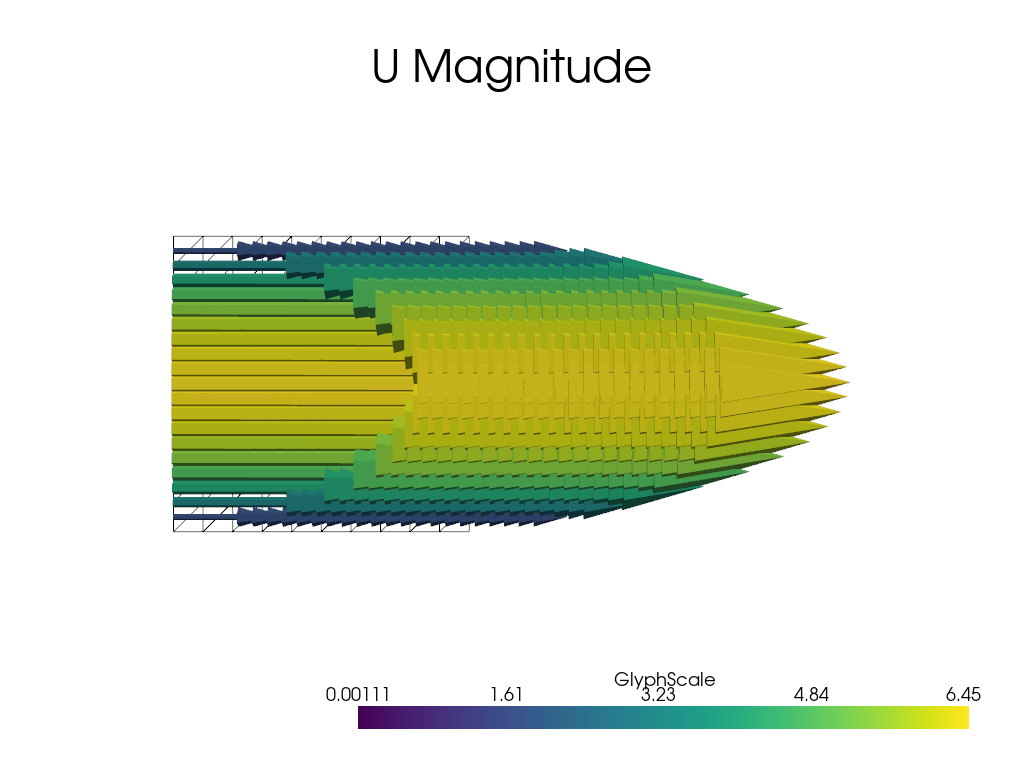

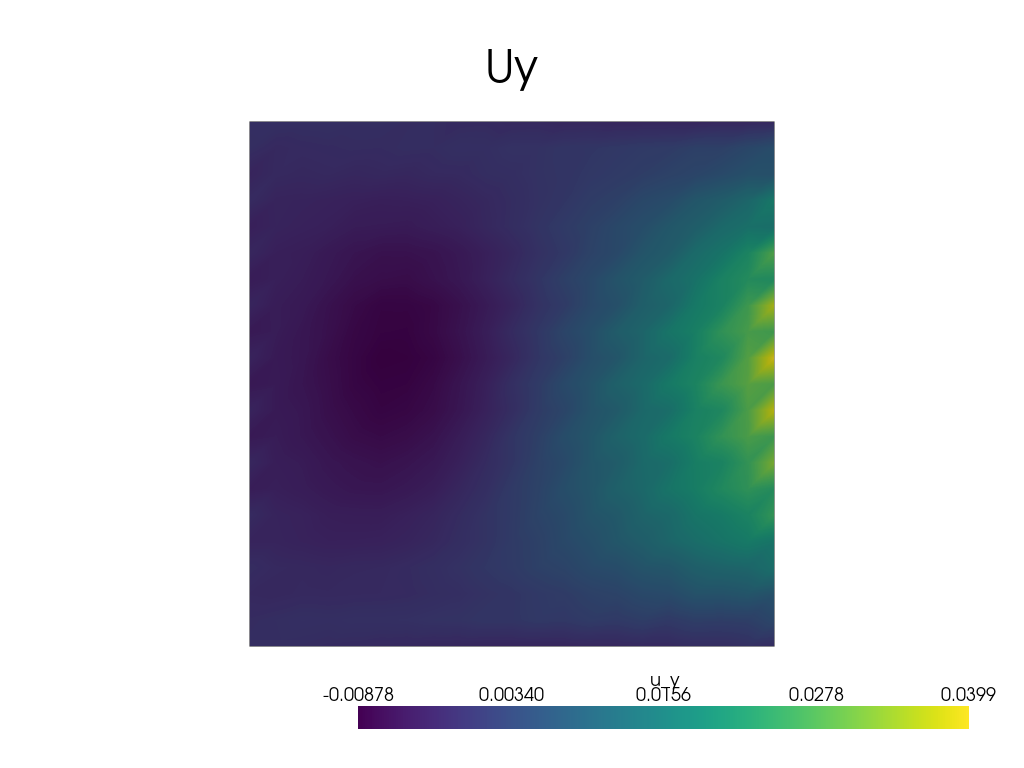

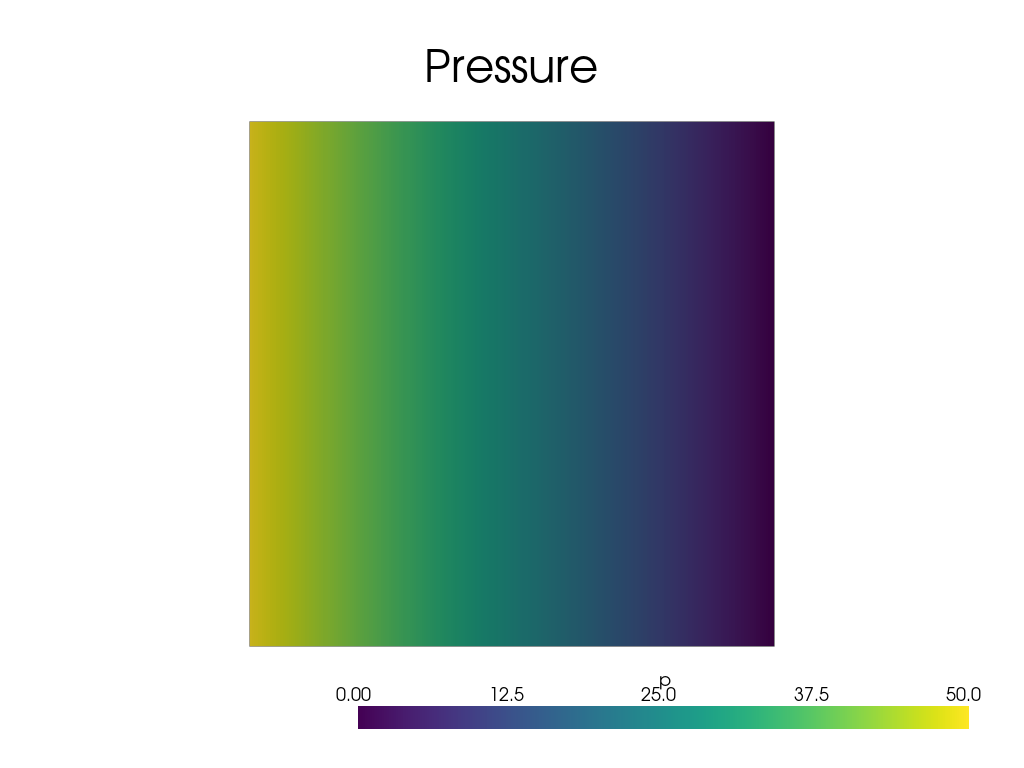

In [2]:
# **** IMPORT *** #

from mpi4py import MPI  # for parallel
from petsc4py import PETSc # matrix solver library
import numpy as np # for array manipulation
import pyvista # visualization
import matplotlib.pyplot as plt

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical # define constants and functions, boundary conditions, 
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc # assemble matrix equations, apply and enforce BC
from dolfinx.io import VTXWriter # write to VTX
from dolfinx.mesh import create_unit_square # create square mesh
from dolfinx.plot import vtk_mesh # plot VTK mesh
from basix.ufl import element # make elements
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction, # face normal vector, identity matrix, test and trial functions
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym) # descirbe the variational form symbolically. math terms


t = 0 # initial time
T = 10 # total simulation time
num_steps = 10 # number of timesteps
dt = T / num_steps # calculate timestep 
maxU = []
maxUerr = []
nx = 10

# *** MESH *** #

mesh = create_unit_square(MPI.COMM_WORLD, nx, nx)
mid = nx / 2

# *** FUNCTION SPACE *** #

# Taylor Hood elements
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, )) # define piecewise quadratic elements, vector should have same dimension as the mesh
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1) # define piecewise linear elements
V = functionspace(mesh, v_cg2) # velocity function space
Q = functionspace(mesh, s_cg1) # pressure function space

# *** TRIAL FUNCTIONS *** #

u = TrialFunction(V) # trial functions for velocity
v = TestFunction(V) # admissable variations of V (velocity)
p = TrialFunction(Q) # trial functions for pressure
q = TestFunction(Q) # admissable variations of Q (pressure)


# *** DEFINE BOUNDARY CONDITIONS *** #

def walls(x): # define where the walls are
        return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], 1))

wall_dofs = locate_dofs_geometrical(V, walls) # find the dofs on the walls
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define no slip zero velocity, velocity vector has same dimension as the mesh
bc_noslip = dirichletbc(u_noslip, wall_dofs, V) # apply no slip to walls dof, array of scalars, V = 0

def inflow(x): # define where the inlet is
    return np.isclose(x[0], 0)

inflow_dofs = locate_dofs_geometrical(Q, inflow) # find dofs at the inlet
bc_inflow = dirichletbc(PETSc.ScalarType(50), inflow_dofs, Q) # assign Dirichlet BC at inlet dofs, p = 8, scalar

def outflow(x): # define where the outlet is
    return np.isclose(x[0], 1)

outflow_dofs = locate_dofs_geometrical(Q, outflow) # find dofs at the outlet
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q) # assign Dirichlet BC at outlet dofs, p = 0, scalar
bcu = [bc_noslip]
bcp = [bc_inflow, bc_outflow]


# *** DEFINE CONSTANTS/VARIABLES *** #

f = Constant(mesh, PETSc.ScalarType((0, 0))) # additional body forces (none here)
k = Constant(mesh, PETSc.ScalarType(dt)) # timestep
mu = Constant(mesh, PETSc.ScalarType(1)) # viscosity
rho = Constant(mesh, PETSc.ScalarType(1)) # density

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))

n = FacetNormal(mesh) # normal vector

# *** FIRST VARIATIONAL FORM *** #

# first variational problem
u_n = Function(V)  # velocity form last time
u_n.name = "u_n" # name the variable
U = 0.5 * (u_n + u) # velocity predictor (u^{n+1/2})

# Define the variational problem for the first step
# <trial function, test function>

p_n = Function(Q) # pressure from last step 
p_n.name = "p_n" # name variable
F1 = rho * dot((u - u_n) / k, v) * dx # first term eq. 39
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx # second term eq.39
F1 += inner(sigma(U, p_n), epsilon(v)) * dx # third term eq. 39
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds # fourth term eq 39
F1 -= dot(f, v) * dx # fifth term eq. 39
a1 = form(lhs(F1)) # a1 = LHS of eq. 39
L1 = form(rhs(F1)) # L1 = rhs of eq. 39

# assemble matrix equation : A1*U = b1
A1 = assemble_matrix(a1, bcs=bcu) # assemble matrix for lhs of 39, note boundary conditions
A1.assemble() # assemble step
b1 = create_vector(L1) # rhs of equation to be solved

# *** SECOND VARIATIONAL FORM *** #

# Define variational problem for step 2
u_ = Function(V) # u_ = velocity prediction (u*)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx) # LHS of eq 40
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx) # rhs of eq 40
A2 = assemble_matrix(a2, bcs=bcp) # assemble matrix with BC
A2.assemble() # assemble
b2 = create_vector(L2) # make vector for rhs
# A2*p = b2

# *** THIRD VARIATIONAL FORM *** #

# Define variational problem for step 3
p_ = Function(Q) # p_ = p from step 2
a3 = form(rho * dot(u, v) * dx) # lhs of (42)
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx) # rhs of (42)
A3 = assemble_matrix(a3) # assemble
A3.assemble() # assemblt
b3 = create_vector(L3) # rhs vector
# A3 * U = b3

# *** SOLVER OPTIONS FOR EACH STEP *** #

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm) # create solver
solver1.setOperators(A1) # set A1 as operator in equation
solver1.setType(PETSc.KSP.Type.BCGS) # use BiConjugate Gradient scheme (nonsymmetric)
pc1 = solver1.getPC() # get preconditioner
pc1.setType(PETSc.PC.Type.HYPRE) # use HYPRE preconditioner
pc1.setHYPREType("boomeramg") # use boomerang method in HYPRE

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm) # create solver
solver2.setOperators(A2) # set A2 as operator
solver2.setType(PETSc.KSP.Type.BCGS) # use BiConjugate Gradient scheme
pc2 = solver2.getPC() # get preconditioner
pc2.setType(PETSc.PC.Type.HYPRE) # use HYPRE preconditioner
pc2.setHYPREType("boomeramg") # use boomerang method in HYPRE

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm) # create solver
solver3.setOperators(A3) # set A3 as operator
solver3.setType(PETSc.KSP.Type.CG) # use conjugate gradient scheme
pc3 = solver3.getPC() # get preconditioner
pc3.setType(PETSc.PC.Type.SOR) # use Gauss Seidel preconditioner

# *** OUTPUT FILES *** #

from pathlib import Path # for navigation
folder = Path("results") # define output directory as pwd/results
folder.mkdir(exist_ok=True, parents=True) # make the output directory and any recursive directories
vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4") # make vtx file for velocity 
vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4") # make vtx file for pressure
vtx_u.write(t) # write time to velocity file
vtx_p.write(t) # write time to pressure file

# *** LOOP OVER TIME TO SOLVE *** #

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1) # rhs of eq 39 is stored in b1 as a vector
    apply_lifting(b1, [a1], [bcu]) # apply BC to the coefficient matrix
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    set_bc(b1, bcu) # set BC on the rhs
    solver1.solve(b1, u_.x.petsc_vec) # solve A1 * u* = b1 based on set schemes
    u_.x.scatter_forward() # sync for parallel processing

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2) # rhs of eq. 40 is stored in b2
    apply_lifting(b2, [a2], [bcp]) # apply BC to the coefficient matrix
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    set_bc(b2, bcp) # set the BC
    solver2.solve(b2, p_.x.petsc_vec) # solve A2*p = b2 based on set schemes
    p_.x.scatter_forward() # sync for parallel processing

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3) # rhs of eq. 42 stored in b3
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    solver3.solve(b3, u_.x.petsc_vec) # solve A3 * u = b3 based on set schemes
    u_.x.scatter_forward() # sync for parallel processing
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

maxU.append(max(u_n.x.petsc_vec.array))



vtx_u.close()
vtx_p.close()
# detroy the solvers and the vectors
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

# *** VISUALIZATION *** #

pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.add_title("U Magnitude")
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")


pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values_y = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values_y[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))


# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u_y"] = values_y[:,1]
#glyphs = function_grid.glyph(orient="p", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(function_grid)
plotter.add_title("Uy")
#plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("Uy.png")

# *** VISUALIZATION PRESSSURE *** #

pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(Q)
values_P = np.zeros((geometry.shape[0], 1), dtype=np.float64)
values_P[:] = p_n.x.array.real.reshape((geometry.shape[0], 1))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["p"] = values_P
#glyphs = function_grid.glyph(orient="p", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(function_grid)
plotter.add_title("Pressure")
#plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("gradP.png")

    
